# Different models

During the project, we experimented a lot with different models, stacks and hyperparameters. We noticed pretty early on that catboost models performed pretty well with our early pipeline.

In [1]:
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

X_A_train = dm.data_A.iloc[:, 2:]
Y_A_train = dm.data_A.iloc[:, 1]

X_B_train = dm.data_B.iloc[:, 2:]
Y_B_train = dm.data_B.iloc[:, 1]

X_C_train = dm.data_C.iloc[:, 2:]
Y_C_train = dm.data_C.iloc[:, 1]

X_A_test = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_test = dm.X_test_estimated_b[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_C_test = dm.X_test_estimated_c[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]


catModel_a = CatBoostRegressor()
catModel_b = CatBoostRegressor()
catModel_c = CatBoostRegressor()

catModel_a.fit(X_A_train,Y_A_train)
catModel_b.fit(X_B_train,Y_B_train)
catModel_c.fit(X_C_train,Y_C_train)

pred_A = catModel_a.predict(X_A_test)
pred_B = catModel_b.predict(X_B_test)
pred_C = catModel_c.predict(X_C_test)

df_A = pd.DataFrame()

df_A["predict"] = pred_A
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["predict"] = pred_B
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["predict"] = pred_C
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df = df.drop("location", axis=1)

df[df<0] = 0

# NAME THE FILE 
df.to_csv("./ext_preds/short_notebook_150.csv")

df.shape

KeyboardInterrupt: 

These predictions consisted of separate models for dataset A, B and C. Since these simple models performed well, we used them a lot for testing feature engineering and other data preprocessing. 

We also experimented with iterations

In [ ]:
catModel_a = CatBoostRegressor(iterations=10000)
catModel_b = CatBoostRegressor(iterations=10000)
catModel_c = CatBoostRegressor(iterations=10000)

With no luck.

Additionally, we tried combining dataset B and C since they have very similar training data. The thought behind this is that we get more data to train on, and thus better results.

In [ ]:
catModel_bc = CatBoostRegressor()

X_BC_train = pd.concat([X_B_train, X_C_train])
Y_BC_train = pd.concat([Y_B_train, Y_C_train])

pred_B = catModel_bc.predict(X_B_test)
pred_C = catModel_bc.predict(X_C_test)

This generally led to worse results.

Though a combined model for all 3 worked in some instances.

In [ ]:
catModel_abc = CatBoostRegressor()

X_BC_train = pd.concat([X_B_train, X_C_train])
Y_BC_train = pd.concat([Y_B_train, Y_C_train])

X_ABC_train = pd.concat([X_A_train, X_BC_train])
Y_ABC_train = pd.concat([Y_A_train, Y_BC_train])

catModel_abc.fit(X_ABC_train,Y_ABC_train)

pred_A = catModel_abc.predict(X_A_test)
pred_B = catModel_abc.predict(X_B_test)
pred_C = catModel_abc.predict(X_C_test)

Other regressor models were tested without any stacking or hyperparameter tuning. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr_a = RandomForestRegressor()
rfr_b = RandomForestRegressor()
rfr_c = RandomForestRegressor()

In [ ]:
from xgboost import XGBRegressor

xgb_a = XGBRegressor()
xgb_b = XGBRegressor()
xgb_c = XGBRegressor()

In [ ]:
from sklearn.neural_network import MLPRegressor

nn_a = MLPRegressor()
nn_b = MLPRegressor()
nn_c = MLPRegressor()

In [ ]:
import lightgbm as lgb

gbm_a = lgb.LGBMRegressor()
gbm_b = lgb.LGBMRegressor()
gbm_c = lgb.LGBMRegressor()

But alone, these models didn't perform any better than catboost

We also experimented with stacking

In [ ]:
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import numpy as np
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

print(dm.data_A.columns)

X_A_train = dm.data_A.iloc[:, 2:]
Y_A_train = dm.data_A.iloc[:, 1]

X_B_train = dm.data_B.iloc[:, 2:]
Y_B_train = dm.data_B.iloc[:, 1]

X_C_train = dm.data_C.iloc[:, 2:]
Y_C_train = dm.data_C.iloc[:, 1]

X_A_test = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_test = dm.X_test_estimated_b[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_C_test = dm.X_test_estimated_c[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]

#X_A_train['direct_rad:W_lag_12']

# remove special characters from column names
X_A_train.columns = X_A_train.columns.str.replace(':', '_')
X_B_train.columns = X_B_train.columns.str.replace(':', '_')
X_C_train.columns = X_C_train.columns.str.replace(':', '_')

X_A_test.columns = X_A_test.columns.str.replace(':', '_')
X_B_test.columns = X_B_test.columns.str.replace(':', '_')
X_C_test.columns = X_C_test.columns.str.replace(':', '_')

# meta models
metaModel_a = LinearRegression()
metaModel_b = LinearRegression()
metaModel_c = LinearRegression()

# stacking classifier
stacking_model_a = StackingRegressor(
    estimators=[('rfr', rfr_a), ('nn', nn_a), ('gbm', gbm_a)],
    final_estimator=metaModel_a
)

stacking_model_b = StackingRegressor(
    estimators=[('rfr', rfr_b), ('nn', nn_b), ('gbm', gbm_b)],
    final_estimator=metaModel_b
)

stacking_model_c = StackingRegressor(
    estimators=[('rfr', rfr_c), ('nn', nn_c), ('gbm', gbm_c)],
    final_estimator=metaModel_c
)

# fit stacking models
stacking_model_a.fit(X_A_train, Y_A_train)
stacking_model_b.fit(X_B_train, Y_B_train)
stacking_model_c.fit(X_C_train, Y_C_train)

# preds for stacking models
stacking_preds_a = stacking_model_a.predict(X_A_test)
stacking_preds_b = stacking_model_b.predict(X_B_test)
stacking_preds_c = stacking_model_c.predict(X_C_test)

Stacking models with catboost gave us some promising results. We calculated the mae between stack predictions and older predictions to determine if the new models could be better.

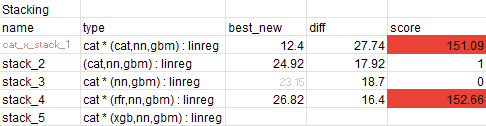

These stacks did not end up being better than our basic catboost model.

We also tried calculating the mean between our best prediction and our stack models, which didnt work either.

In [ ]:
pred_A_new = np.mean([pred_a, stacking_preds_a], axis=0)
pred_B_new = np.mean([pred_b, stacking_preds_b], axis=0)
pred_C_new = np.mean([pred_c, stacking_preds_c], axis=0)

df_A = pd.DataFrame()

df_A["predict"] = pred_A_new
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["predict"] = pred_B_new
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["predict"] = pred_C_new
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df = df.drop("location", axis=1)

df[df<0] = 0

# NAME THE FILE 
df.to_csv("./ext_preds/stack_4.csv")

df.shape

### Hyperparameter tuning
To improve our models, we also tried a lot of hyperparameter tuning, where we experimented with different tools like Optuna, Scikit-Optimize and H2O. As Optuna worked pretty well, we included it in our pipeline for some models

In [ ]:
from sklearn.model_selection import train_test_split 

X = dm.data.iloc[:, 2:]
y = dm.data.iloc[:, 1]


X_A = dm.data_A.iloc[:, 2:-1]
y_A = dm.data_A.iloc[:, 1]
X_B = dm.data_B.iloc[:, 2:-1]
y_B = dm.data_B.iloc[:, 1]
X_C = dm.data_C.iloc[:, 2:-1]
y_C = dm.data_C.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, train_size=0.6, shuffle=False)

X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_A)
X_A_validate, X_A_test, y_A_validate, y_A_test = train_test_split(X_A_test, y_A_test, train_size=0.5, shuffle=False)

X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B)
X_B_validate, X_B_test, y_B_validate, y_B_test = train_test_split(X_B_test, y_B_test, train_size=0.5, shuffle=False)

X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C)
X_C_validate, X_C_test, y_C_validate, y_C_test = train_test_split(X_C_test, y_C_test, train_size=0.5, shuffle=False)

X_BC = dm.data[dm.data["location"] != 0]

y_BC = X_BC.iloc[:, 1]
X_BC = X_BC.iloc[:, 2:]

X_BC_train, X_BC_test, y_BC_train, y_BC_test = train_test_split(X_BC, y_BC, shuffle=False)
X_BC_validate, X_BC_test, y_BC_validate, y_BC_test = train_test_split(X_BC_test, y_BC_test, train_size=0.5, shuffle=False)

X_BC_submission = dm.X_test_estimated[dm.X_test_estimated["location"] != 0].iloc[:, 1:]

X_submission = dm.X_test_estimated[dm.X_test_estimated.columns.intersection(X.columns)]

X_A_submission = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A.columns)]
X_B_submission = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B.columns)]
X_C_submission = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C.columns)]

print(X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape, X_submission.shape)

print(X_A_train.shape, y_A_train.shape, X_A_validate.shape, y_A_validate.shape, X_A_test.shape, y_A_test.shape, X_A_submission.shape)
print(X_B_train.shape, y_B_train.shape, X_B_validate.shape, y_B_validate.shape, X_B_test.shape, y_B_test.shape, X_B_submission.shape)
print(X_C_train.shape, y_C_train.shape, X_C_validate.shape, y_C_validate.shape, X_C_test.shape, y_C_test.shape, X_C_submission.shape)

print(X_BC_train.shape, y_BC_train.shape, X_BC_validate.shape, y_BC_validate.shape, X_BC_test.shape, y_BC_test.shape, X_BC_submission.shape)

X_BC_submission

In [ ]:

import optuna
import numpy as np
from sklearn.metrics import mean_absolute_error
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        #"iterations": trial.suggest_int("iterations", 10, 1500),
        "random_seed": 0,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb = CatBoostRegressor(**param)

    cb.fit(X_train, y_train, eval_set=[(X_validate, y_validate)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = mean_absolute_error(y_test, pred_labels)
    return accuracy

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, timeout=None)

We tried optuna with different catboost variations. A combined model for A, B and C ended up giving us the best result.

In [ ]:
#[I 2023-11-05 16:59:05,004] Trial 5 finished with value: 116.02466557883027 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08555204354589313, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'iterations': 1190, 'bagging_temperature': 5.833922769277539}. Best is trial 5 with value: 116.02466557883027.

# these params scored 150 
# ("cat", CatBoostRegressor(**{'objective': 'MAE', 'colsample_bylevel': 0.08393035401844894, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6491381658313076, "random_seed":0})),

# [I 2023-11-05 22:37:34,489] Trial 20 finished with value: 161.77335724365003 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09961018030513795, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.755437017114945}. Best is trial 20 with value: 161.77335724365003.

## DELETED FEATS 

## with validation split 
#[I 2023-11-06 10:05:05,399] Trial 26 finished with value: 165.8851952022578 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09930576154462276, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 165.8851952022578.
#[I 2023-11-06 09:59:39,114] Trial 13 finished with value: 165.99023283160864 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09894236237775247, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 165.99023283160864.

## DELETED FEATS + LAG FEATS - SUM RAD
#[I 2023-11-06 14:18:01,581] Trial 26 finished with value: 165.43080979284372 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09922457244655024, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 26 with value: 165.43080979284372.
#[I 2023-11-06 14:14:27,365] Trial 22 finished with value: 166.69347928436912 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07845778545183921, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 166.69347928436912.


## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (12/3)
#[I 2023-11-06 18:47:26,359] Trial 12 finished with value: 169.74903878583473 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07321108308140112, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9947382455838534}. Best is trial 12 with value: 169.74903878583473.
#[I 2023-11-06 18:45:18,746] Trial 11 finished with value: 171.92396530956395 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.068755243871172, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9942926270291108}. Best is trial 11 with value: 171.92396530956395.
#[I 2023-11-06 18:51:54,938] Trial 15 finished with value: 170.281074439894 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08074887258271649, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.10570616951506}. Best is trial 12 with value: 169.74903878583473.


# [I 2023-11-05 22:43:53,232] Trial 2 finished with value: 25.414357904741664 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06927535477671466, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10515029581800527}. Best is trial 2 with value: 25.414357904741664.

# DELETED FEATS 

## Proper validation: 
#[I 2023-11-06 10:26:38,751] Trial 25 finished with value: 22.26772405170921 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09981161016617257, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5119008311351512}. Best is trial 25 with value: 22.26772405170921.
#[I 2023-11-06 10:35:56,976] Trial 33 finished with value: 22.62602913068846 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0953035979637657, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4988564621460619}. Best is trial 25 with value: 22.26772405170921.


## DELETED FEATS + LAG FEATS - SUM RAD


# [I 2023-11-05 23:01:43,697] Trial 12 finished with value: 22.37118032357372 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06718168961955846, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3200703207067206}. Best is trial 12 with value: 22.37118032357372.

# DELETED FEATS 

#proper validatioon 
#[I 2023-11-06 10:45:49,758] Trial 28 finished with value: 20.537135559921417 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09350538147690629, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.842124245488673}. Best is trial 28 with value: 20.537135559921417.
#[I 2023-11-06 10:43:30,999] Trial 22 finished with value: 20.997127701375245 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08944284279926223, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.930004930966931}. Best is trial 22 with value: 20.997127701375245.
#[I 2023-11-06 10:59:09,821] Trial 33 finished with value: 19.716058939096268 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09644126188381036, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9881316487405227}. Best is trial 33 with value: 19.716058939096268.
#[I 2023-11-06 10:57:44,252] Trial 31 finished with value: 19.721968565815324 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09517386033361759, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9934480446809176}. Best is trial 31 with value: 19.721968565815324.
#[I 2023-11-06 10:57:04,178] Trial 30 finished with value: 20.012184675834973 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09999890845914448, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9877850694321213}. Best is trial 30 with value: 20.012184675834973.


## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (20/3)
#[I 2023-11-06 18:55:46,070] Trial 0 finished with value: 18.485309556165106 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09003451962386975, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1912152898699087}. Best is trial 0 with value: 18.485309556165106.
#[I 2023-11-06 19:16:42,672] Trial 3 finished with value: 17.818673155834432 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0819245485589076, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 17.818673155834432.
#[I 2023-11-06 19:16:46,131] Trial 4 finished with value: 20.735737001810563 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.03948636560626, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 17.818673155834432.


#[I 2023-11-06 09:21:40,140] Trial 7 finished with value: 93.57082723599223 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07021145849459196, 'depth': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 93.57082723599223.
#[I 2023-11-06 09:18:27,362] Trial 6 finished with value: 104.18112832124598 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07343258702862919, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 99.6739211164172.
#[I 2023-11-06 09:18:19,613] Trial 4 finished with value: 99.6739211164172 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.05987187094961611, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8627037092982467}. Best is trial 4 with value: 99.6739211164172.

## PROPER VALIDATION 
# [I 2023-11-06 09:34:06,886] Trial 11 finished with value: 94.84395099535925 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06788514856337621, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3089743943699958}. Best is trial 1 with value: 91.96302490499082.
# [I 2023-11-06 09:34:12,735] Trial 12 finished with value: 90.99607534299506 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06879424422985089, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1356440119309477}. Best is trial 12 with value: 90.99607534299506.
# [I 2023-11-06 09:34:19,982] Trial 13 finished with value: 90.15040743548006 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.06831027771726123, 'depth': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1059090481359448}. Best is trial 13 with value: 90.15040743548006.
# [I 2023-11-06 09:34:49,324] Trial 14 finished with value: 85.26022828486518 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0764308167143037, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11317034357345056}. Best is trial 14 with value: 85.26022828486518.
# [I 2023-11-06 09:36:04,025] Trial 15 finished with value: 81.02983953897846 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08556050159260666, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10142252384867761}. Best is trial 15 with value: 81.02983953897846.
# USED THIS FOR SUB CATBOOST_13_SINGLE.CSV [I 2023-11-06 09:37:51,323] Trial 16 finished with value: 78.62797533658944 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09994261947773965, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3517029793822252}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:39:42,441] Trial 17 finished with value: 78.80238554236068 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09990666905586555, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.39528335187495645}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:12,070] Trial 18 finished with value: 82.74867457461298 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09991105102282588, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.44205347186589705}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:19,573] Trial 19 finished with value: 86.11596511811832 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0993444194374076, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4163694923198905}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:40:24,566] Trial 20 finished with value: 95.64983586751998 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08625070811470684, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5965498517007939}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:41:48,783] Trial 21 finished with value: 80.34018050497714 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08828388798152162, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29136732663727677}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:42:34,832] Trial 22 finished with value: 81.1204320957182 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.0918243857157667, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35999148599335806}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:44:15,154] Trial 23 finished with value: 79.2280725426542 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09386351381323012, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.29478409296370756}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:44:42,818] Trial 24 finished with value: 81.19963365555299 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09997495410247971, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4802613284856091}. Best is trial 16 with value: 78.62797533658944.
# [I 2023-11-06 09:45:01,658] Trial 25 finished with value: 85.19633893372021 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07924963444764457, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 78.62797533658944.

## DELETED FEATS + LAG FEATS - SUM RAD
# USED THIS FOR SUB CATBOOST_14_SINGLE.CSV [I 2023-11-06 16:04:47,625] Trial 41 finished with value: 83.411573402198 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09618156200475811, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21387042043411192}. Best is trial 41 with value: 83.411573402198.
# [I 2023-11-06 15:44:49,977] Trial 30 finished with value: 83.51429978562304 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09926156367081514, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.271617400472478}. Best is trial 30 with value: 83.51429978562304.
# [I 2023-11-06 15:29:27,387] Trial 24 finished with value: 84.02207338155672 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09850904799670648, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2994539222163096}. Best is trial 24 with value: 84.02207338155672.

## ALL FEATS + FE, NO LAG FEATS, BC DONATION AND REMOVING CONST INTERVALS (20/3)
#[I 2023-11-06 21:22:41,277] Trial 18 finished with value: 19.06275303157211 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.08101231188824651, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1203886158980404}. Best is trial 18 with value: 19.06275303157211.
#[I 2023-11-06 21:25:20,073] Trial 21 finished with value: 19.02159924912772 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.07731293544992492, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3756198315698245}. Best is trial 21 with value: 19.02159924912772.
#[I 2023-11-06 21:30:31,243] Trial 25 finished with value: 18.844086323227387 and parameters: {'objective': 'MAE', 'colsample_bylevel': 0.09981161016617257, 'depth': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5119008311351512}. Best is trial 25 with value: 18.844086323227387.


## Training on summer months exclusively
Since we are doing predictions on summer months solely, we had an idea to try and remove all training data for other seasons

In [ ]:
def filter_by_month(df: pd.DataFrame, months: list[str]) -> pd.DataFrame:
    """
    Filter a dataframe by keeping only rows where the 'date_forecast' column is within the specified months.

    Parameters:
    df (pandas.DataFrame): The dataframe to filter.
    months (list[str]): A list of months to keep, in the format 'MM'.

    Returns:
    pandas.DataFrame: The filtered dataframe.
    """
    return df[df['date_forecast'].dt.strftime('%m').isin(months)]

In [ ]:
from helpers import filter_by_month

dml.data_A = filter_by_month(dml.data_A, ['04','05','06','07'])
dml.data_B = filter_by_month(dml.data_B, ['04','05','06','07'])
dml.data_C = filter_by_month(dml.data_C, ['04','05','06','07'])
%store dml

Though this did not improve the score. 

